# Multi-Objective Resource Allocation Method for IoT applications in the context of Mobile Edge Computing (MEC)

## Dépendances
Import des dépendances Python nécessaires au projet.

In [33]:
import numpy as np

## Dataset
Cette partie décrit le dataset et les données utilisées pour répondre au problème décrit plus bas.

Données en fonction d’autres données :
- $TE_m=TM_m+TW_m+TB_m$ le temps total de complétion d’une tâche $atn_m$
- $TM_m$ 
- $TW_m$
- $TB_m$
- $msu_n$ la moyenne de l’utilisation du serveur $men_n$
- $ZYS$ le compte total des VMs occupées (tous serveurs)
- $MSU$ la variance de l’équilibre de charge des serveurs 
- $wnt_n$ le temps maximum de complétion d’une tâche par le serveur $men_n$
- $ECB$ la consommation d’énergie pour un serveur $men_n$ en fonctionnement
- $ECF$ la consommation pour toutes les VMs occupées
- $ECK$ la consommation pour toutes les VMs inoccupées
- $EC$ la consommation totale d’énergie par le set de serveurs $MEN$

#### Constantes pour le Load Balancing

In [34]:
# taille des VMs découlent de la taille de la tâche.

# nombre de VMs par serveurs déjà exprimé dans la RAS

#### Constantes pour le temps de complétion des tâches

In [35]:
# Taille de la tâche en unités de données
G = 5  # = RG = GR
wk = {0:0.75, 1:1.25, 2:0.3} # Bande passante selon le cas j = 0, 1, 2
wnt = []
S = 5

#### Constantes pour la consommation d'énergie

In [36]:
# Constantes pour la consommation d'énergie
rx = 0.2 # Wattage d'un serveur allumé
rf = 0.125 # Wattage d'une VM occupée
rn = 0.5 # Wattage d'une VM non occupée

### Paramètres expérimentaux
>On considère qu'une application ne génère qu'une seule tâche. Le nombre de tâches est donc directement corellé avec le nombre d'applications IoT.

In [37]:
# Paramètre de nombre d'applications IoT
nb_app = [50, 100, 150, 200, 250]
# Paramètre de nombre de serveurs MEC
nb_serv = 15
# Paramètre du nombre de VM par serveur MEC
nb_vm = 8
# Paramètre de la quantité de VM nécessaire par application
vm_cost = np.random.randint(1, 7, size=nb_app[0])
# Paramètre de la taille de la VM à exécuter
size_vm = 5

### Constantes

In [38]:
# Wattage des serveurs
pr_serv = 350
# Wattage des VM occupées
pr_ovm = 75
# Wattage des VM inoccupées
pr_uvm = 45

## Implémentation de Firefly

### Paramètres de Firefly

### Algorithme

In [39]:
def fitness(position,vm_cost , w1, w2, w3):

  # Calcul des fonctions objectifs
  TE, MSU, EC = 0, 0, 0
  ZYS = 0
  msu_list = []
  # On commence par calculer pour chaque serveur :

  
  for n in range(nb_serv):
    # Liste des temps de complétion de tâches pour le serveur n :
    temps_compl = [0] # On y place les temps de complétion calculés pour chaque tâche pour le serveur n
    msu_n = 0 # Load balancing pour le serveur n

    # On regarde combien de tâches sont assignées au serveur n
    nb_taches = 0
    for i in range(nb_app[0]):
      if position[i, n] == 1:
        nb_taches += 1
    print("Nombre de tâches assignées au serveur n : ", nb_taches)
    # Parcours des tâches assignées à chaque serveur
    for m in range(nb_app[0]):
      # On récupère le coût en VMs de la tâche m dans la matrice tasks_assign
      VM_cost = vm_cost[m]
      
      # Si la tâche n'est pas assignée au serveur n, on passe à la tâche suivante
      if VM_cost == 0:
        continue

      # Si VM_cost < nb_vm, on peut exécuter la tâche sur le serveur n exclusivement
      if VM_cost < nb_vm:
        j = 0
      # Si VM_cost >= nb_vm et VM_cost < nb_serv*nb_vm, on peut exécuter la tâche sur le serveur n et d'autres serveurs
      elif VM_cost >= nb_vm and VM_cost < nb_serv*nb_vm:
        j = 1
      else:
        j = 2

      # Calcul du temps de récupération de la tâche.
      TM_m = 0
      if j == 0:
        TM_m = G / wk[0] # Temps de complétion de la tâche m sur le serveur n, en assumant que la tâche est de taille G
      elif j == 1:
        TM_m = G / wk[0] + G / wk[1] # Temps de complétion de la tâche m sur le serveur n, en assumant que la tâche est de taille G
      else:
        TM_m = G / wk[0] + G / wk[1] + G / wk[2] # Temps de complétion de la tâche m sur le serveur n, en assumant que la tâche est de taille G

      # Calcul du temps de retour de la tâche.
      TB_m = 0
      if j == 0:
        TB_m = G / wk[0] # Temps de complétion de la tâche m sur le serveur n, en assumant que la tâche est de taille G
      elif j == 1:
        TB_m = G / wk[0] + G / wk[1]
      else:
        TB_m = G / wk[0] + G / wk[1] + G / wk[2]

      # Calcul du temps de complétion de la tâche m sur le serveur n
      TW_m = G / S * nb_taches # Temps de complétion de la tâche m sur le serveur n, en assumant que la tâche est de taille G et que le serveur a une puissance de calcul S
      temps_compl.append(TW_m)

      TE += (TM_m + TB_m + TW_m)

      # Calcul de la variance du load balancing
      def phi(position):
        if position == 0:
          return 0
        else:
          return 1
      msu_n += (1/nb_vm)*phi(position[m, n]) # Load balancing pour le serveur n et la tâche m
      
    # FIN BOUCLE TÂCHES
    # On sauve la msu_n 
    msu_list.append(msu_n)
    ZYS += (1/nb_serv)*msu_n # Compte total des VMs occupées par les tâches assignées à chaque serveur

    # Maintenant que les temps de complétion ont été calculés, on prend le max pour le serveur n
    max_temps = np.max(temps_compl)
    ECB_n = max_temps*pr_serv
    ECF_n = 0
    pECK_n = 0
    # On calcule la consommation d'énergie pour le serveur n en parcourant les tâches assignées
    for m in range(nb_app[0]):
      VM_cost = vm_cost[m]
      if VM_cost == 0:
        continue

      
      ECF_n += max_temps*pr_ovm*phi(position[m, n])
      pECK_n += max_temps*pr_uvm*phi(position[m, n])
    
    ECK_n = ZYS - pECK_n
    EC += (ECF_n + ECK_n + ECB_n)
  
  # On parcours la liste des msu pour calculer la variance
  for msu in msu_list:
    MSU += (1/nb_serv)*((msu - ZYS)**2)

  # print("===Début solution===")
  # print ("Variance de load balancing calculée : ", MSU)
  # print ("Temps d'exécution total : ", TE)
  # print ("Consommation d'énergie totale : ", EC)
  # print("===Fin solution===")

  # Fonction multiobjectives pondérée (c'est comme ça qu'on rend firefly multi-objectif)
  return w1 * TE + w2 * MSU + w3 * EC, MSU, TE, EC




In [40]:
def allocation_taches_serveurs(nb_taches, nb_serveurs, nb_vms_par_serveur):
    # On assigne aléatoirement les tâches aux serveurs 
    # 0 = tâche non assignée, 1 = tâche assignée

    # On crée une matrice de taille nb_taches x nb_serveurs
    position = np.zeros((nb_taches, nb_serveurs))

    # On assigne les tâches aux serveurs
    for i in range(nb_taches):
        # On tire un nombre aléatoire entre 0 et nb_serveurs
        serveur = np.random.randint(0, nb_serveurs)
        position[i, serveur] = 1

    return position



In [41]:
class FireflyAlgorithmMultiObjective:
    def __init__(self, fitness_func=fitness,
                dim=(nb_app[0],nb_serv),
                n_fireflies=50,
                max_iter=100,
                alpha=0.2,
                beta0=1,
                gamma=1,
                delta=1,
                lower_bound=None,
                upper_bound=None,
                vm_cost = np.random.randint(1, 7, size=nb_app[0]),
                w1 = 1,
                w2 = 1,
                w3 = 1
                ):
        self.fitness_func = fitness_func
        self.dim = dim 
        self.n_fireflies = n_fireflies
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma
        self.delta = delta
        self.lower_bound = lower_bound if lower_bound is not None else np.zeros(dim)
        self.upper_bound = upper_bound if upper_bound is not None else np.ones(dim)
        self.vm_cost = vm_cost
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        
        self.population = np.array([allocation_taches_serveurs(nb_app[0], nb_serv, nb_vm) for _ in range(n_fireflies) ])
        self.intensities = np.array([self.fitness_func(ind,self.vm_cost, self.w1, self.w2, self.w3)[0] for ind in self.population])
        print(self.intensities)

        self.MSU = np.array([self.fitness_func(ind,self.vm_cost, self.w1, self.w2, self.w3)[1] for ind in self.population])
        self.TE = np.array([self.fitness_func(ind,self.vm_cost, self.w1, self.w2, self.w3)[2] for ind in self.population])
        self.EC = np.array([self.fitness_func(ind,self.vm_cost, self.w1, self.w2, self.w3)[3] for ind in self.population])
        self.non_dominated_archive = self.identify_non_dominated(self.population, self.MSU, self.TE, self.EC)
        
    def identify_non_dominated(self, population, MSU, TE, EC):
        non_dominated_archive = []
        for i in range(len(population)):
            dominated = False
            for j in range(len(population)):
                if MSU[j] != MSU[i] or TE[j] != TE[i] or EC[j] != EC[i]:
                    if MSU[j] <= MSU[i] and TE[j] <= TE[i] and EC[j] <= EC[i]:
                        dominated = True
                        break
            if not dominated:
                non_dominated_archive.append(i)
        return non_dominated_archive
        
    def move_firefly(self, source, target):
        distance = np.linalg.norm(source - target)
        beta = self.beta0 * np.exp(-self.gamma * distance**2)
        new_position = source + beta * (target - source) + self.alpha * (np.random.randn(nb_app[0],nb_serv) - 0.5)
        return np.clip(new_position, self.lower_bound, self.upper_bound)
    
    def update_non_dominated_archive(self):
        
        for i in range(self.n_fireflies):
            for j in range(self.n_fireflies):
                if i in self.non_dominated_archive or j in self.non_dominated_archive:
                    if self.MSU[j] != self.MSU[i] or self.TE[j] != self.TE[i] or self.EC[j] != self.EC[i]:
                        if self.MSU[j] <= self.MSU[i] and self.TE[j] <= self.TE[i] and self.EC[j] <= self.EC[i]:
                            self.non_dominated_archive.append(j)
        
        self.non_dominated_archive = list(set(self.non_dominated_archive))
        
    def optimize(self):
        for t in range(self.max_iter):
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if self.intensities[i] < self.intensities[j]:
                        self.population[i] = self.move_firefly(self.population[i], self.population[j])
                        self.intensities[i], self.MSU[i], self.TE[i], self.EC[i] = self.fitness_func(self.population[i],self.vm_cost, self.w1, self.w2, self.w3)
            self.update_non_dominated_archive()
            self.alpha *= self.delta
        return self.population[self.non_dominated_archive], self.intensities[self.non_dominated_archive], self.MSU[self.non_dominated_archive], self.TE[self.non_dominated_archive], self.EC[self.non_dominated_archive]



In [42]:
# Test
nb_fireflies = 10
nb_iterations = 50
w1 = 0.2
w2 = 0.3
w3 = 0.5
# Paramètres de l'algorithme Firefly
alpha = 0.5  # Coefficient d'absorption
beta = 0.6  # Coefficient de randomisation
gamma = 1.0  # Facteur d'atténuation

fa = FireflyAlgorithmMultiObjective(n_fireflies=nb_fireflies, max_iter=nb_iterations, alpha=alpha, beta0=beta, gamma=gamma,vm_cost=vm_cost, w1=w1, w2=w2, w3=w3)
solutions, intensities, MSU, TE, EC = fa.optimize()

Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  4
Nombre de tâches assignées au serveur n :  5
Nombre de tâches assignées au serveur n :  0
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  6
Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  4
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  5
Nombre de tâches assignées au serveur n :  4
Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  5
Nombre de tâches assignées au serveur n :  6
Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  0
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  6
Nombre de tâches assignées au serveur n :  6
Nombre de 

Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  5
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  3
Nombre de tâches assignées au serveur n :  5
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  7
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  4
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  2
Nombre de tâches assignées au serveur n :  4
Nombre de tâches assignées au serveur n :  1
Nombre de tâches assignées au serveur n :  5
Nombre de tâches assignées au serveur n :  0
Nombre de 

In [43]:
print("Solution finale : ", solutions)
print("Intensités : ", intensities)

Solution finale :  [[[0.         0.         0.38380738 ... 0.17275268 0.52149743 0.        ]
  [0.         0.         0.15363186 ... 0.         0.         0.        ]
  [0.         0.89240709 0.         ... 0.36084817 0.         0.35475025]
  ...
  [0.         0.32144683 0.54013446 ... 0.         0.49783519 0.13361532]
  [0.         0.97345772 0.56181158 ... 0.         0.64801403 0.51008881]
  [0.         0.         0.10336554 ... 0.77485214 0.0658384  0.        ]]

 [[0.         1.         0.25328683 ... 0.         1.         0.        ]
  [0.33542488 0.         0.5297861  ... 0.         0.         0.        ]
  [0.         0.37487828 0.6801346  ... 0.         0.48923636 0.21507827]
  ...
  [0.35307946 0.88842984 0.         ... 0.         0.         0.        ]
  [0.38055028 0.         0.38527904 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.02071511 0.         0.         ... 0.         0.         0.25458051]
  [

In [44]:
print(solutions[0])

[[0.         0.         0.38380738 0.37192141 0.05593174 0.35881653
  0.         0.         0.         0.54011321 0.         0.
  0.17275268 0.52149743 0.        ]
 [0.         0.         0.15363186 1.         0.         0.62389787
  1.         0.         0.         0.         1.         0.7962079
  0.         0.         0.        ]
 [0.         0.89240709 0.         0.         0.26309994 0.11855045
  0.42291497 0.         0.         0.01052516 0.         0.
  0.36084817 0.         0.35475025]
 [0.         0.15818776 0.89719857 0.         0.         0.
  0.         0.37911419 0.         0.88090891 0.         0.
  0.61449615 0.         0.        ]
 [0.49294531 0.         0.         0.         0.01786135 0.
  0.50476508 0.         0.         0.         0.2717207  0.0183092
  0.         0.         0.        ]
 [0.46394153 0.         0.         0.20886798 0.         0.75891223
  0.         0.         0.00366875 0.16936725 0.         0.
  0.32348319 0.88574426 0.        ]
 [0.         0.   

In [45]:
# On converti la solution en matrice binaire
solution = np.array([np.round(sol) for sol in solutions])
print("Solution binaire : ", solution)

MSUs = []
TEs = []
ECs = []

for i in range(len(solution)):
    MSUs.append(fitness(solution[i], vm_cost, w1, w2, w3)[1])
    TEs.append(fitness(solution[i], vm_cost, w1, w2, w3)[2])
    ECs.append(fitness(solution[i], vm_cost, w1, w2, w3)[3])

Solution binaire :  [[[0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 1. 1.]
  [0. 0. 0. ... 1. 0. 0.]]

 [[0. 1. 0. ... 0. 1. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 1. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 1. 0.]]

 [[0. 0. 1. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  ...
  [1. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 1. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 1. 0. 0.]
  [1. 1. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0.

In [46]:
print(solution[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.

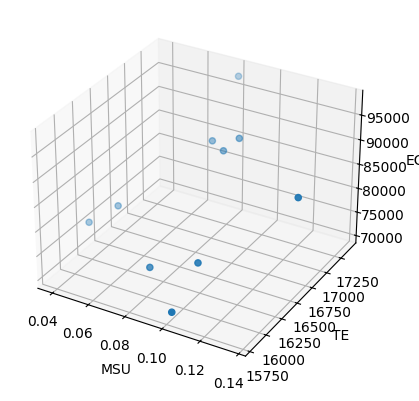

In [47]:
# On affiche les solutions dans un graphique 3D
# Axes : MSU, TE, EC

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(MSUs, TEs, ECs)

ax.set_xlabel('MSU')
ax.set_ylabel('TE')
ax.set_zlabel('EC')

plt.show()

In [48]:
# On utilise graph_object pour afficher le graphique 3D
import plotly.graph_objects as go


fig = go.Figure(data=[go.Scatter3d(x=MSUs, y=TEs, z=ECs, mode='markers', marker=dict(size=5, color='blue', opacity=0.8))])
# Axes
fig.update_layout(scene = dict(
                    xaxis_title='MSU',
                    yaxis_title='TE',
                    zaxis_title='EC'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))

fig.show()